In [1]:
# 1) Import TimeSeries and ARIMA from their new locations
import pandas as pd
import numpy as np

# Generate a sample time series DataFrame
date_rng = pd.date_range(start='2025-01-01', periods=100, freq='h')
df = pd.DataFrame({
    'time': date_rng,
    'feature1': np.random.randn(len(date_rng)),
    'feature2': np.random.randn(len(date_rng)),
    'feature3': np.random.randn(len(date_rng)),
    'slev': np.random.randn(len(date_rng))
})

df

,date,feature1,feature2,feature3,slev
0,2025-01-01 00:00:00,-0.186536,-1.454731,-0.828960,-1.140857
1,2025-01-01 01:00:00,-0.139292,2.502697,-1.728764,0.916599
2,2025-01-01 02:00:00,-1.790022,0.233592,-0.729033,-0.570201
3,2025-01-01 03:00:00,-0.415800,0.883090,-0.616796,0.978127
4,2025-01-01 04:00:00,0.877103,-2.057169,0.320872,1.096148
...,...,...,...,...,...
95,2025-01-04 23:00:00,-1.534973,-0.623891,-1.886299,-0.041779
96,2025-01-05 00:00:00,-0.065073,1.129806,0.185662,1.212869
97,2025-01-05 01:00:00,0.994296,1.252656,-0.162076,-0.250417
98,2025-01-05 02:00:00,0.594572,-0.133834,0.302236,-1.129979


Daten umwandeln

In [3]:
import pandas as pd

# Deine Daten
df = df.rename(columns={'slev': 'y',
                        'time': 'ds',})


df['unique_id'] = 'Flensburg'  # Dummy-ID für einzelne Zeitreihe

df

,ds,feature1,feature2,feature3,y,unique_id
0,2025-01-01 00:00:00,-0.186536,-1.454731,-0.828960,-1.140857,Flensburg
1,2025-01-01 01:00:00,-0.139292,2.502697,-1.728764,0.916599,Flensburg
2,2025-01-01 02:00:00,-1.790022,0.233592,-0.729033,-0.570201,Flensburg
3,2025-01-01 03:00:00,-0.415800,0.883090,-0.616796,0.978127,Flensburg
4,2025-01-01 04:00:00,0.877103,-2.057169,0.320872,1.096148,Flensburg
...,...,...,...,...,...,...
95,2025-01-04 23:00:00,-1.534973,-0.623891,-1.886299,-0.041779,Flensburg
96,2025-01-05 00:00:00,-0.065073,1.129806,0.185662,1.212869,Flensburg
97,2025-01-05 01:00:00,0.994296,1.252656,-0.162076,-0.250417,Flensburg
98,2025-01-05 02:00:00,0.594572,-0.133834,0.302236,-1.129979,Flensburg


In [4]:
n_future = 24


2. 📊 Daten vorbereiten

Wir benötigen ein DataFrame mit mindestens folgenden Spalten:

    unique_id: eine ID für jede Zeitreihe

    ds: Timestamps (datetime oder string)

    y: Zielwert

Definieren von train und test data

In [5]:
# Erstelle einen train/test Split
train = df[:-48]
test = df[-48:]

display(train.head())
print("Train set shape:", train.shape)
print("Test set shape:", test.shape)
display(test.head())

,ds,feature1,feature2,feature3,y,unique_id
0,2025-01-01 00:00:00,-0.186536,-1.454731,-0.828960,-1.140857,Flensburg
1,2025-01-01 01:00:00,-0.139292,2.502697,-1.728764,0.916599,Flensburg
2,2025-01-01 02:00:00,-1.790022,0.233592,-0.729033,-0.570201,Flensburg
3,2025-01-01 03:00:00,-0.415800,0.883090,-0.616796,0.978127,Flensburg
4,2025-01-01 04:00:00,0.877103,-2.057169,0.320872,1.096148,Flensburg


Train set shape: (52, 6)
Test set shape: (48, 6)


,ds,feature1,feature2,feature3,y,unique_id
52,2025-01-03 04:00:00,0.665163,-0.664491,0.703559,0.459596,Flensburg
53,2025-01-03 05:00:00,0.788758,-0.946393,0.761258,-0.953508,Flensburg
54,2025-01-03 06:00:00,0.626801,-1.201988,0.029569,0.140272,Flensburg
55,2025-01-03 07:00:00,-1.105522,0.899941,0.367596,1.593775,Flensburg
56,2025-01-03 08:00:00,1.433373,-1.129658,1.148941,-0.763180,Flensburg


In [7]:
test.head()

,ds,feature1,feature2,feature3,y,unique_id
52,2025-01-03 04:00:00,0.665163,-0.664491,0.703559,0.459596,Flensburg
53,2025-01-03 05:00:00,0.788758,-0.946393,0.761258,-0.953508,Flensburg
54,2025-01-03 06:00:00,0.626801,-1.201988,0.029569,0.140272,Flensburg
55,2025-01-03 07:00:00,-1.105522,0.899941,0.367596,1.593775,Flensburg
56,2025-01-03 08:00:00,1.433373,-1.129658,1.148941,-0.763180,Flensburg


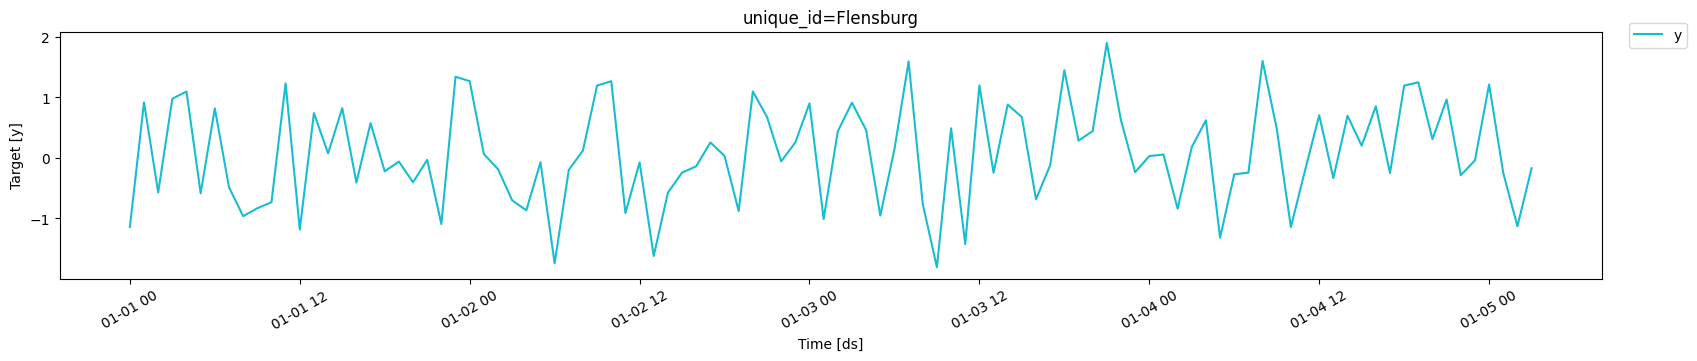

In [8]:
from utilsforecast.plotting import plot_series

fig = plot_series(
    df=train[['unique_id', 'ds', 'y']],
    forecasts_df=test[['unique_id', 'ds', 'y']],
    time_col='ds', target_col='y',
    id_col='unique_id',
)
fig

3. ⚙️ Modell definieren

In [26]:
from sklearn.ensemble import RandomForestRegressor
from mlforecast import MLForecast
from mlforecast.utils import generate_daily_series

# Modell + mlforecast Wrapper
model = MLForecast(
    models=[RandomForestRegressor(n_jobs=-1)],
    freq='h',
    lags=[1, 2],             # Lag Features
    #date_features=['dayofweek']  # Kalenderspezifische Features
)


4. 🧠 Feature Engineering mit Lags

mlforecast erzeugt aus dem Originaldatenframe automatisch Features wie:

    lag1: Wert 1 Tag zurück

    lag7: Wert 7 Tage zurück

    dayofweek: Wochentag (0 = Montag, 6 = Sonntag)

In [27]:
model.fit(train, static_features=[])


# Vorhersage der nächsten 24 h pro Zeitreihe
predictions = model.predict(h=n_future, X_df=test)
print(predictions.head())

   unique_id                  ds  RandomForestRegressor
0  Flensburg 2025-01-03 04:00:00              -0.016533
1  Flensburg 2025-01-03 05:00:00               0.359762
2  Flensburg 2025-01-03 06:00:00               0.243478
3  Flensburg 2025-01-03 07:00:00               0.144085
4  Flensburg 2025-01-03 08:00:00               0.412422


In [34]:
from sklearn.ensemble import RandomForestRegressor
from mlforecast import MLForecast


# Modell + mlforecast Wrapper
model = MLForecast(
    models=[RandomForestRegressor(n_jobs=-1)],
    freq='h',
    lags=[1, 2],             # Lag Features
    #date_features=['dayofweek']  # Kalenderspezifische Features
)


model.fit(train, static_features=[], keep_last_n=10)

# Vorhersage der nächsten 24 h pro Zeitreihe
predictions = model.predict(h=10)
print(predictions.head())

KeyError: "['feature1', 'feature2', 'feature3'] not in index"

6. 📈 Visualisierung

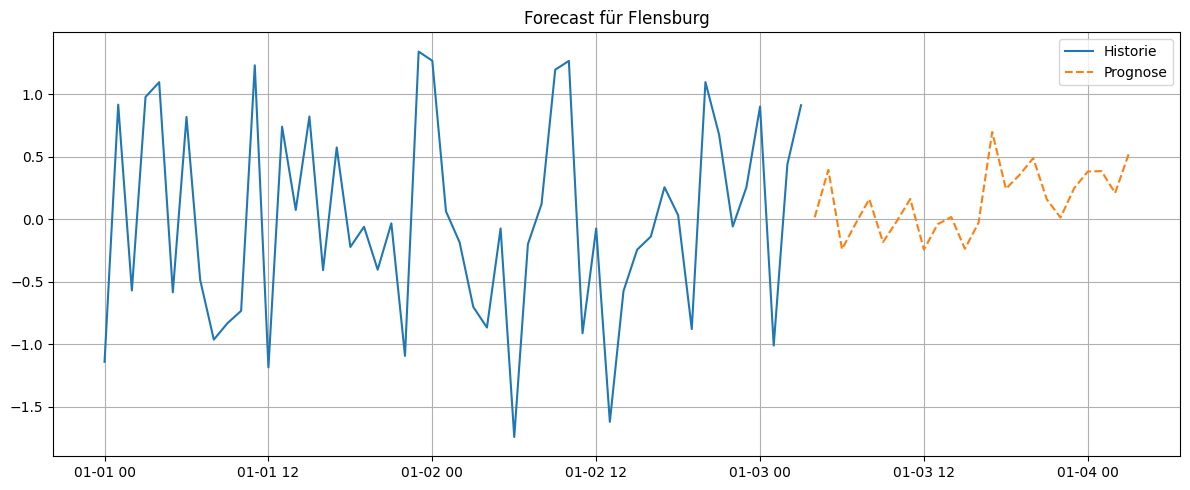

In [15]:
import matplotlib.pyplot as plt

def plot_forecast(original_df, pred_df, ts_id='Flensburg'):
    df_plot = original_df[original_df['unique_id'] == ts_id]
    pred_plot = pred_df[pred_df['unique_id'] == ts_id]
    
    plt.figure(figsize=(12, 5))
    plt.plot(df_plot['ds'], df_plot['y'], label='Historie')
    plt.plot(pred_plot['ds'], pred_plot['RandomForestRegressor'], label='Prognose', linestyle='--')
    plt.legend()
    plt.title(f'Forecast für {ts_id}')
    plt.grid()
    plt.tight_layout()
    plt.show()

plot_forecast(train, predictions, ts_id='Flensburg')


## Optuna

In [8]:
import pandas as pd
import numpy as np

# Beispiel: 1 Zeitreihe mit Rauschen + Trend
np.random.seed(42)
dates = pd.date_range('2020-01-01', periods=300)
df = pd.DataFrame({
    'unique_id': 'ts1',
    'ds': dates,
    'y': np.sin(np.linspace(0, 10, 300)) + np.random.normal(0, 0.3, 300)
})


🔁 3. TimeSeriesSplit vorbereiten

In [9]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3, test_size=30)


🔍 4. Optuna Objective-Funktion

In [10]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from mlforecast import MLForecast

def objective(trial):
    # Hyperparameter-Vorschläge
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
        n_jobs=-1
    )
    
    rmses = []

    # Cross-Validation
    for train_idx, val_idx in tscv.split(df):
        df_train = df.iloc[train_idx]
        df_val = df.iloc[val_idx]

        forecast = MLForecast(
            models=[model],
            freq='D',
            lags=[1, 7, 14],
            date_features=['dayofweek', 'day', 'month']
        )

        forecast.fit(df_train)

        horizon = len(df_val)
        preds = forecast.predict(horizon)

        # RMSE berechnen
        y_true = df_val['y'].values
        y_pred = preds['y'].values[:horizon]

        rmse = mean_squared_error(y_true, y_pred, squared=False)
        rmses.append(rmse)

    return np.mean(rmses)


/home/razer/documents/Masterarbeit_code/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


⚙️ 5. Studie starten

In [11]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("Beste Parameter:")
print(study.best_params)


[I 2025-06-01 13:41:25,036] A new study created in memory with name: no-name-87d27bd9-f472-4e53-925a-f76d9405ebd5
[W 2025-06-01 13:41:26,629] Trial 0 failed with parameters: {'n_estimators': 173, 'max_depth': 3, 'min_samples_split': 4} because of the following error: KeyError('y').
Traceback (most recent call last):
  File "/home/razer/documents/Masterarbeit_code/.venv/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'y'

The above exception was the direct cause of the following exception:

Tr

KeyError: 'y'

✅ 6. Bestes Modell trainieren & vorhersagen

In [ ]:
best_model = RandomForestRegressor(
    **study.best_params,
    random_state=42,
    n_jobs=-1
)

final_forecast = MLForecast(
    models=[best_model],
    freq='D',
    lags=[1, 7, 14],
    date_features=['dayofweek', 'day', 'month']
)

final_forecast.fit(df)

forecast_horizon = 30
final_preds = final_forecast.predict(forecast_horizon)
print(final_preds.head())


📈 7. Visualisierung

NameError: name 'final_preds' is not defined

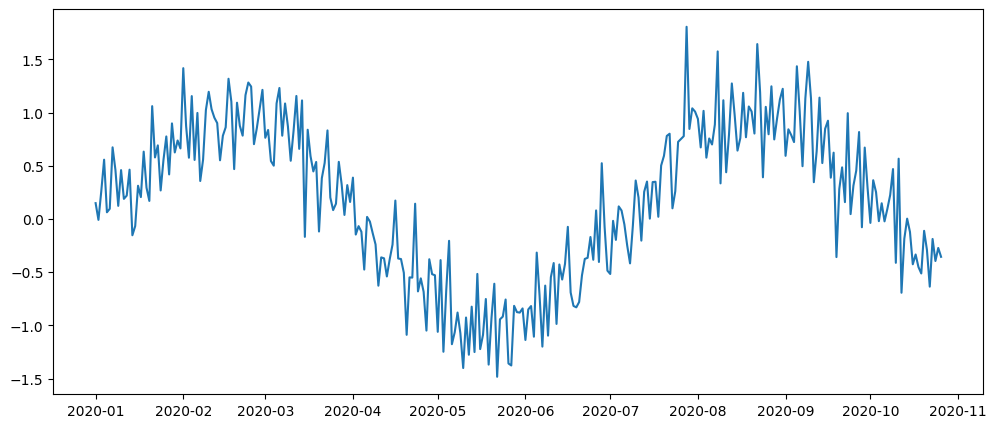

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df['ds'], df['y'], label='Historisch')
plt.plot(final_preds['ds'], final_preds['y'], label='Vorhersage', linestyle='--')
plt.axvline(df['ds'].iloc[-1], color='grey', linestyle=':')
plt.legend()
plt.title('Zeitreihen-Vorhersage mit Optimierten Parametern')
plt.grid()
plt.tight_layout()
plt.show()


🧠 Optional: Studie speichern & laden

In [ ]:
# import joblib

# # Speichern
# joblib.dump(study, 'optuna_study_rf.pkl')

# # Laden
# # study = joblib.load('optuna_study_rf.pkl')
